## Different ensemble methods for classification trees

In this notebook you will use scikit-learn's trees and ensemble methods to compare different 'forests' and their performance on some toy datasets. In particular, you will

1. train single Trees (deterministic and random ones, both greedy and random spilts) on the full data set, and compare performances.
2. train multiple of them using bootstrapped samples of the data. compare performance vs. number of trees used.
3. visualize some of the classifiers in 2d.
4. train vs out ouf bag vs. test error vs. crossvalidation error.


As usual, some setup first:

In [1]:
import numpy as np
import sklearn.tree as sk_tree
import sklearn.ensemble as sk_ensemble
import sklearn.datasets as sk_data
import sklearn.cross_validation as sk_cv
import warnings
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

/usr/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


The data set is a very simple example from scikit_learns datasets submodule. It's two dimensional, so you can visualize the classifiers.

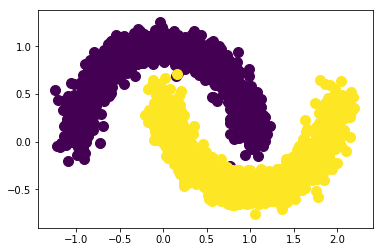

In [2]:
# pick one of these 2d datasets
X, Y = sk_data.make_moons(2000, noise=0.1)
#X,Y = sk_data.make_blobs(n_samples=100, n_features=2, centers=4, center_box=(-8,8))

num_classes = len(np.unique(Y))
cms = plt.cm.viridis

for c in range(num_classes):
    idx = (Y == c)
    plt.scatter(X[idx, 0], X[idx,1], c = cms(c/(num_classes-1)), s=100)
plt.show()

n=100
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, n),
                     np.linspace(y_min, y_max, n))

Here are two convinience functions that let you plot the 'decision boundaries' of a classifiers. The first one will plot all points that would be classified the same in the same color. The second one shows a more complex picture. It overlays all classes with the alpha value determined by the fraction of the samples in a particular leaf. That means, it illustrates the confidence of a tree.
Feel free to use any of them for the remainder of the notebook.


In [3]:
def classification_plot_max(trained_classifier, title, ax):
    probs = trained_classifier.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    
    for c in range(num_classes):
        tmp = np.array((np.argmax(probs, axis=1) == c).reshape(xx.shape), dtype=np.float)
        tmp = cms(tmp)
        ax.imshow(tmp, origin='lower', extent=[np.min(xx), np.max(xx), np.min(yy), np.max(yy)], alpha=0.8)
        idx = (Y == c)
        ax.scatter(X[idx, 0], X[idx,1], c = cms(c/(num_classes-1)), s=10)
        if title is not None:
            ax.set_title(title)

def classification_plot_alpha(trained_classifier, title, ax):
    for c in range(num_classes):
        alphas = trained_classifier.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,c].reshape(xx.shape)
        tmp = cms(c/(num_classes-1)*np.ones_like(xx))
        tmp[:,:,3] = alphas
        ax.imshow(tmp, origin='lower', extent=[np.min(xx), np.max(xx), np.min(yy), np.max(yy)], alpha=0.8)
        idx = (Y == c)
        ax.scatter(X[idx, 0], X[idx,1], c = cms(c/(num_classes-1)), s=10)
        if title is not None:
            ax.set_title(title)
        ax.set_xlim([x_min, x_max])
        ax.set_ylim([y_min, y_max])

classification_plot = classification_plot_alpha

Let's look at some simple tree examples:

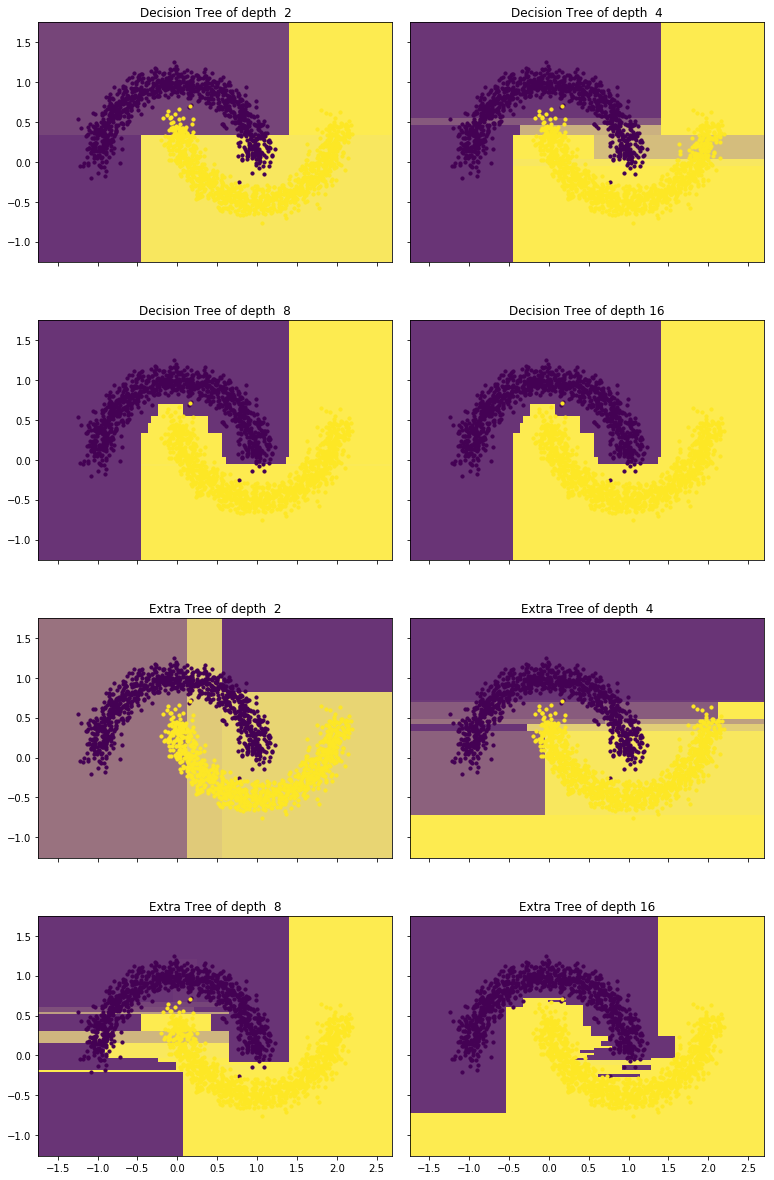

In [4]:
classifiers = [("Decision Tree of depth  2", sk_tree.DecisionTreeClassifier(max_depth=2)),
               ("Decision Tree of depth  4", sk_tree.DecisionTreeClassifier(max_depth=4)),
               ("Decision Tree of depth  8", sk_tree.DecisionTreeClassifier(max_depth=8)),
               ("Decision Tree of depth 16", sk_tree.DecisionTreeClassifier(max_depth=16)),
               ("Extra Tree of depth  2", sk_tree.ExtraTreeClassifier(max_depth=2)),
               ("Extra Tree of depth  4", sk_tree.ExtraTreeClassifier(max_depth=4)),
               ("Extra Tree of depth  8", sk_tree.ExtraTreeClassifier(max_depth=8)),
               ("Extra Tree of depth 16", sk_tree.ExtraTreeClassifier(max_depth=16))
            ]
f, axarr = plt.subplots(len(classifiers)//2, 2, figsize=(13,21), sharey=True, sharex=True)

for i, (name, classifier) in enumerate(classifiers):
    classifier.fit(X,Y)
    classification_plot(classifier, name, axarr[i//2, i%2])

f.subplots_adjust(hspace=0.2, wspace=0.05)
plt.show()
    

Now it's your turn to draw similar pictures for the following classifiers:
1. bagged classification trees
2. random forests
3. extra trees

All are accessible in scikit learn.


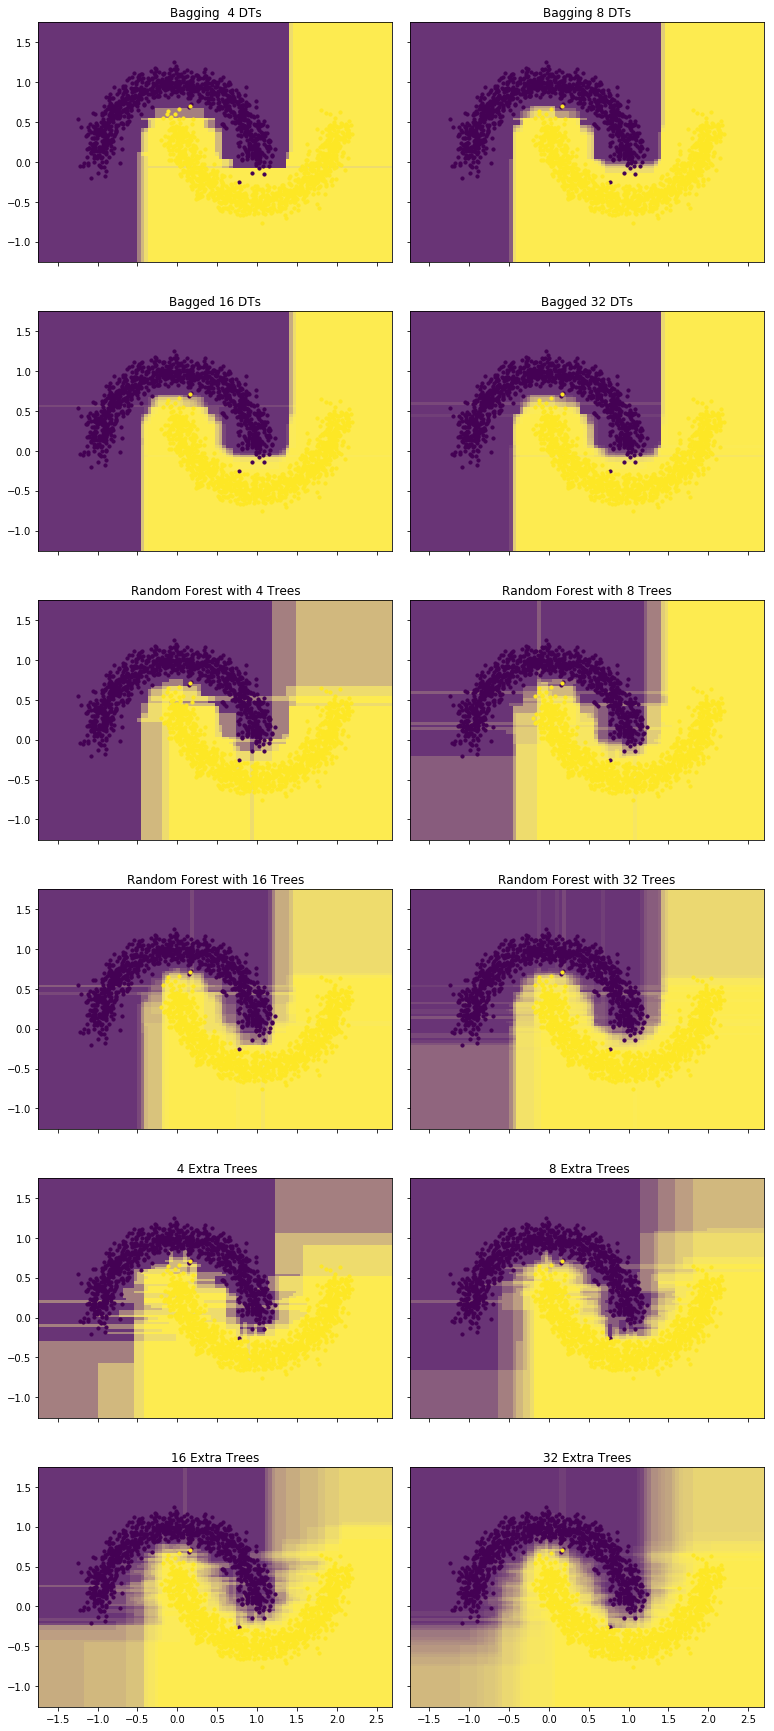

In [5]:
# Insert code below
classifiers = [("Bagging  4 DTs", sk_ensemble.BaggingClassifier(sk_tree.DecisionTreeClassifier(), n_estimators=4)),
               ("Bagging 8 DTs", sk_ensemble.BaggingClassifier(sk_tree.DecisionTreeClassifier(), n_estimators=8)),
               ("Bagged 16 DTs", sk_ensemble.BaggingClassifier(sk_tree.DecisionTreeClassifier(), n_estimators=16)),
               ("Bagged 32 DTs", sk_ensemble.BaggingClassifier(sk_tree.DecisionTreeClassifier(), n_estimators=32)),         
               ("Random Forest with 4 Trees", sk_ensemble.RandomForestClassifier(n_estimators=4)),
               ("Random Forest with 8 Trees", sk_ensemble.RandomForestClassifier(n_estimators=8)),
               ("Random Forest with 16 Trees", sk_ensemble.RandomForestClassifier(n_estimators=16)),
               ("Random Forest with 32 Trees", sk_ensemble.RandomForestClassifier(n_estimators=32)),
               (" 4 Extra Trees", sk_ensemble.ExtraTreesClassifier(n_estimators=4)),
               (" 8 Extra Trees", sk_ensemble.ExtraTreesClassifier(n_estimators=8)),
               ("16 Extra Trees", sk_ensemble.ExtraTreesClassifier(n_estimators=16)),
               ("32 Extra Trees", sk_ensemble.ExtraTreesClassifier(n_estimators=32)),

            ]

f, axarr = plt.subplots(len(classifiers)//2, 2, figsize=(13,31), sharey=True, sharex=True)

for i, (name, classifier) in enumerate(classifiers):
    classifier.fit(X,Y)
    classification_plot(classifier, name, axarr[i//2, i%2])

f.subplots_adjust(hspace=0.2, wspace=0.05)
plt.show()

Let's see how the ensemble methods generalize and how the out of bag error estimates the validation error. To make things a bit more interesting, we shall use a higher dimensional problem with more classes and more features.

In [6]:
X,Y = sk_data.make_classification(10000, n_features=20, n_classes = 4, n_informative = 4)
X_train, X_test, Y_train, Y_test = sk_cv.train_test_split(X, Y, test_size=0.33)

/usr/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


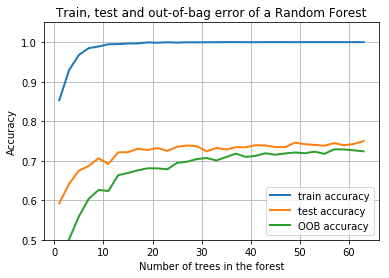

In [7]:
import warnings
num_trees = range(1,65,2)
accuracies = []
for nt in num_trees:
    # Sometimes not every input point was 'out of bag' and scikit learn raises a warning when computing the OOB-score.
    # This just supresses this warning to unclutter the notebook.
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        rf = sk_ensemble.RandomForestClassifier(n_estimators=nt, bootstrap=True, oob_score=True)
        rf.fit(X_train, Y_train)
    accuracies.append((rf.score(X_train, Y_train), rf.score(X_test, Y_test), rf.oob_score_))
accuracies = np.array(accuracies)
plt.plot(num_trees, accuracies[:,0], label='train accuracy', linewidth=2)
plt.plot(num_trees, accuracies[:,1], label='test accuracy', linewidth=2)
plt.plot(num_trees, accuracies[:,2], label='OOB accuracy', linewidth=2)
plt.ylim([0.5,1.05])
plt.title("Train, test and out-of-bag error of a Random Forest")
plt.xlabel("Number of trees in the forest")
plt.ylabel("Accuracy")
plt.grid('on','both')
plt.legend(loc=4)
plt.show()

### Question:

What are advantages/disadvantages of using the out-of-bag error rather than the 'traditional' train/test split?

Now let's apply this to a 'real' dataset and investigate some more. In the cell below, the iris data set is loaded. Add code to compute:
1. the training error
2. the test error
3. the out of bag error
4. a crossvalidation estimate of the error using 4-fold CV

for different numbers of trees.

Create plots similar to the one above for a random forests and extra trees. What do you observe?

/usr/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


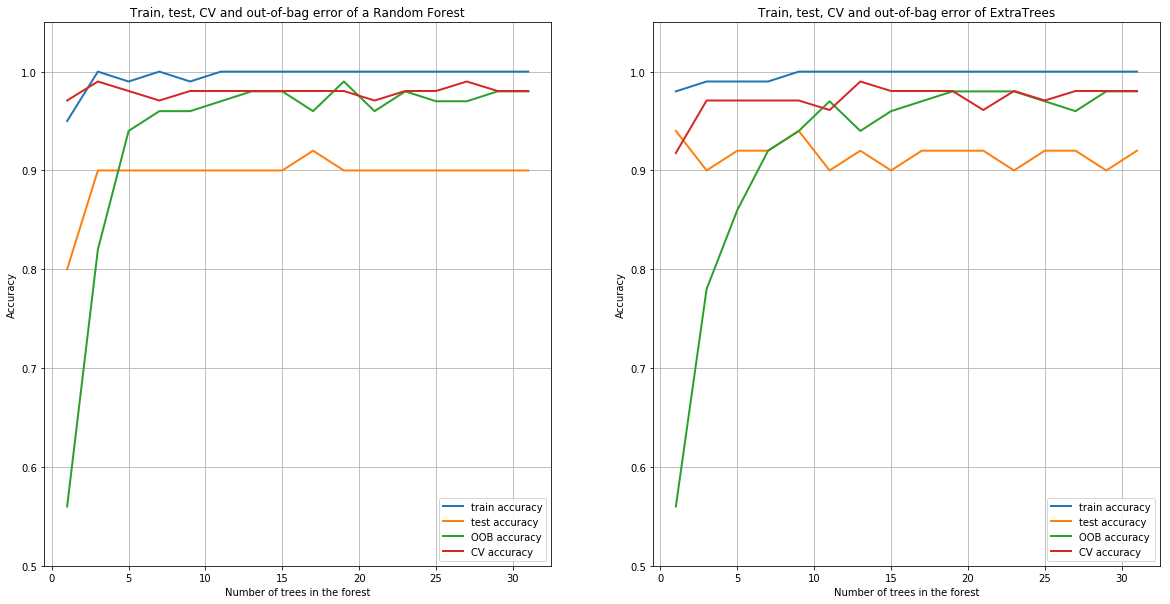

In [8]:
# We use the Iris data from the first exercise sheet
X_train = np.loadtxt('iris_train.data', delimiter=' ', dtype=float)
Y_train = np.loadtxt('iris_train.labels', dtype=int)
X_test = np.loadtxt('iris_test.data', delimiter=' ', dtype=float)
Y_test = np.loadtxt('iris_test.labels', dtype=int)

# Insert code below!

num_trees = range(1,32,2)
accuracies = []
for nt in num_trees:
    # Sometimes not every input point was 'out of bag' and scikit learn raises a warning when computing the OOB-score.
    # This just supresses this warning to unclutter the notebook.
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        rf = sk_ensemble.RandomForestClassifier(n_estimators=nt, bootstrap=True, oob_score=True, random_state=None)
        rf.fit(X_train, Y_train)
        train_acc = rf.score(X_train, Y_train)
        test_acc = rf.score(X_test, Y_test)
        oob = rf.oob_score_
        cv_score = sk_cv.cross_val_score(rf, X_train, Y_train, cv=4).mean()
    accuracies.append((train_acc, test_acc, oob, cv_score))
    
accuracies_rf = np.array(accuracies)

accuracies = []
for nt in num_trees:
    # Supress warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        ets = sk_ensemble.ExtraTreesClassifier(n_estimators=nt, bootstrap=True, oob_score=True, random_state=None)
        ets.fit(X_train, Y_train)
        train_acc = ets.score(X_train, Y_train)
        test_acc = ets.score(X_test, Y_test)
        oob = ets.oob_score_
        cv_score = sk_cv.cross_val_score(ets, X_train, Y_train, cv=4).mean()
    accuracies.append((train_acc, test_acc, oob, cv_score))


accuracies_ets = np.array(accuracies)


f, (rf_ax, ets_ax) = plt.subplots(1, 2, figsize=(20,10))

rf_ax.plot(num_trees, accuracies_rf[:,0], label='train accuracy', linewidth=2)
rf_ax.plot(num_trees, accuracies_rf[:,1], label='test accuracy', linewidth=2)
rf_ax.plot(num_trees, accuracies_rf[:,2], label='OOB accuracy', linewidth=2)
rf_ax.plot(num_trees, accuracies_rf[:,3], label='CV accuracy', linewidth=2)
rf_ax.set_ylim([0.5,1.05])
rf_ax.set_title("Train, test, CV and out-of-bag error of a Random Forest")
rf_ax.set_xlabel("Number of trees in the forest")
rf_ax.set_ylabel("Accuracy")
rf_ax.grid('on','both')
rf_ax.legend(loc=4)

ets_ax.plot(num_trees, accuracies_ets[:,0], label='train accuracy', linewidth=2)
ets_ax.plot(num_trees, accuracies_ets[:,1], label='test accuracy', linewidth=2)
ets_ax.plot(num_trees, accuracies_ets[:,2], label='OOB accuracy', linewidth=2)
ets_ax.plot(num_trees, accuracies_ets[:,3], label='CV accuracy', linewidth=2)
ets_ax.set_ylim([0.5,1.05])
ets_ax.set_title("Train, test, CV and out-of-bag error of ExtraTrees")
ets_ax.set_xlabel("Number of trees in the forest")
ets_ax.set_ylabel("Accuracy")
ets_ax.grid('on','both')
ets_ax.legend(loc=4)


plt.show()